Cambiar el archivo SentenceTransformer.py en sentence-transformer e instalar con pip install -e sentence-transforme

In [1]:
from sentence_transformers import SentenceTransformer, models, datasets
from torch import nn
from sentence_transformers import LoggingHandler, SentenceTransformer, util, InputExample
import torch
from torch.utils.data import DataLoader
from sentence_transformers import evaluation
import pandas as pd
from sentence_transformers import models, losses
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import random
import csv
import json
from glob import glob
from sklearn.model_selection import train_test_split
import os
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

## Experiment Config

Descomentar para el backbone deseado. Luego se puede Restart & Run all

In [2]:
### CONFIG
#### Beto
#model_path = 'beto-sentemb'
#hugging_face_model_name = 'espejelomar/beto-base-cased'
#batch_size = 64

#### Bertin
model_path = 'bertin-hugenli'
hugging_face_model_name = 'bertin-project/bertin-roberta-base-spanish'
batch_size = 64

#### Roberta
#model_path = 'roberta-sentemb'
#hugging_face_model_name = 'PlanTL-GOB-ES/roberta-base-bne'
#batch_size = 64


In [3]:
torch.cuda.get_device_name(0)

'NVIDIA A10'

## Modelo

Siguiendo el esquema de entrenamiento para NLI de [este paper](https://arxiv.org/pdf/1908.10084.pdf).

Dimensiones a *ojímetro*.

In [4]:
word_embedding_model = models.Transformer(hugging_face_model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(),
                           out_features=512, #ojimetro
                           activation_function=nn.Tanh())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])
model.cuda()

Some weights of the model checkpoint at bertin-project/bertin-roberta-base-spanish were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at bertin-project/bertin-roberta-base-spanish and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

SentenceTransformer(
  (0): Transformer({'max_seq_length': 514, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

## Dataset

Ver el dataset:
```
esxnli = pd.read_table('esxnli.tsv')
label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}
es_only_data = esxnli[esxnli.language == 'es']
es_only_data[['language', 'sentence1', 'sentence2', 'gold_label', 'promptID', 'pairID', 'genre', 'label1']]
```

Datos de entrenamiento en NLI

In [5]:
# Creditos a Omar Espejel
train_data = {}

def add_to_samples(sent1, sent2, label):
    if label in ['contradiction', 'entailment', 'neutral']:
        if sent1 not in train_data:
            train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
        train_data[sent1][label].add(sent2)
    else:
        pass

Add ESXNLI

In [6]:
with open('esxnli.tsv') as dataset:
  reader = csv.DictReader(dataset, delimiter='\t', quoting=csv.QUOTE_NONE)
  for row in reader:
    if row['language'] == 'es':
      
      sent1 = row['sentence1'].strip()
      sent2 = row['sentence2'].strip()
    
      add_to_samples(sent1, sent2, row['gold_label'])
      add_to_samples(sent2, sent1, row['gold_label'])  #Also add the opposite

In [7]:
# Add SNLI and MultiNLI
snli_root = 'data'
snli_files = glob(snli_root+'/snli_*')
snli_files.append(snli_root+'/multinli_1.0_train_translated1.jsonl')

for fname in snli_files:
    print('Loading: {}'.format(fname))
    with open(fname) as fl:
        for entry in fl:
            row = json.loads(entry)
            sent1 = row['sentence1'].strip()
            sent2 = row['sentence2'].strip()
            add_to_samples(sent1, sent2, row['gold_label'])
            add_to_samples(sent2, sent1, row['gold_label'])  #Also add the opposite

Loading: data/snli_1.0_train_translated3.jsonl
Loading: data/snli_1.0_train_translated2.jsonl
Loading: data/snli_1.0_train_translated1.jsonl
Loading: data/snli_1.0_train_translated0.jsonl
Loading: data/snli_1.0_train_translated5.jsonl
Loading: data/snli_1.0_train_translated4.jsonl
Loading: data/multinli_1.0_train_translated1.jsonl


In [8]:
# create dataloader
train_samples = []
for sent1, others in train_data.items():
    if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
        train_samples.append(InputExample(texts=[sent1, random.choice(list(others['entailment'])), random.choice(list(others['contradiction']))]))
        train_samples.append(InputExample(texts=[random.choice(list(others['entailment'])), sent1, random.choice(list(others['contradiction']))]))

# Special data loader that avoid duplicates within a batch
train_dataloader = datasets.NoDuplicatesDataLoader(train_samples, batch_size=64)

Datos de testing en STS

In [9]:
sts_root = 'sts2015-es'
sts_files = [('STS.gs.newswire.txt', 'STS.input.newswire.txt'),
             ('STS.gs.wikipedia.txt', 'STS.input.wikipedia.txt')]

dev_examples = []
for gs_fname, sents_fname in sts_files:
    gs = open(os.path.join(sts_root, gs_fname))
    sents = open(os.path.join(sts_root, sents_fname))
    for g, s in zip(gs, sents):
        sent1, sent2 = s.split('\t')
        dp = InputExample(texts=[sent1, sent2], label=float(g)/5)
        dev_examples.append(dp)
gs.close()
sents.close()
    
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_examples, batch_size=batch_size,
                                                             name='sts-dev')

In [10]:
float('1.6')/5

0.32

## Callback 

In [11]:
class Printable:
    def __init__(self, skip: int = 1) -> None:
        """
        Params
        ------
        skip: int, optional
          skip every skip epochs. Default: 1
        """
        self.skip = skip
  
    def __call__(self, score, epoch, steps) -> None:
        if epoch % self.skip == 0:
            print('--- Evaluation report ---')
            print('Epoch {}: {}'.format(epoch, score))
            
callback = Printable(skip=5)

## Loss

In [12]:
# Our training loss
train_loss = losses.MultipleNegativesRankingLoss(model)

## Training

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=20,
          warmup_steps=100, evaluator=evaluator,
          output_path=model_path, show_progress_bar=True)
          #output_path='beto-sentemb', show_progress_bar=True, callback=callback)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1127 [00:00<?, ?it/s]

## Inspeccionar loss y performance

In [7]:
from savitzky_golay import savitzky_golay
with open(os.path.join('bertin-stsv2','loss_digest.json')) as fl:
    historic_loss = json.load(fl)

Text(0, 0.5, 'Loss0')

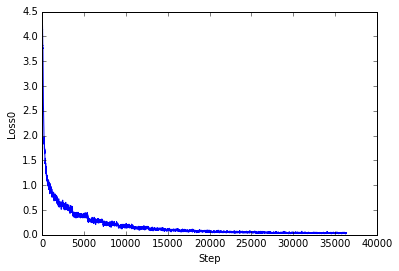

In [8]:
#hloss, ltype = np.log(np.array(historic_loss['0'])), 'log '  # <--- log domain
hloss, ltype = np.array(historic_loss['0']), ''  # <--- dominio clasico
hloss = savitzky_golay(hloss, 53, 4)
plt.plot(range(len(historic_loss['0'])), hloss)
plt.xlabel('Step')
plt.ylabel(ltype+'Loss0')
#plt.legend('Loss0', ncol=2, loc='upper left');

In [6]:
evaluation = pd.read_csv(os.path.join(model_path, 'eval/similarity_evaluation_sts-dev_results.csv'))
evaluation.drop(columns=['steps']).groupby('epoch').mean().loc[[0,5,10,15,19]]

FileNotFoundError: [Errno 2] No such file or directory: 'bertin-hugenli/eval/similarity_evaluation_sts-dev_results.csv'